## Fit baseline model using flight delay averages

- Takes the model input data for flight delays
- Split data based on external train/test data file
- Define baseline average model
- Evaluate model
- Save model as pickle
- -- save to mlflow -- 
- Write prediction prediction output to csv

### Parameters

-------------------
- `input_file`: Filepath of model input data of flight delays
- `train_test_file`: Filepath of train/test csv file with columns ["id", "model_set"]
- `output_file`: Filepath to write output csv file with minimal modelling input


### Returns

-----------------

Trained baseline model that simply predicts the average flight delay from the training
data in all predictions.


In [2]:
input_file = "../lvt-schiphol-assignment-snakemake/data/model_input/delays_base_input.csv"
train_test_file = "../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__sample.csv"
output_predictions = "./predictions.csv"

In [3]:
from pathlib import Path
output_dir = Path(output_predictions).parent.absolute()
output_dir

WindowsPath('C:/Users/Lodewic/qualogy-git/schiphol-assignment/scripts')

## Imports

In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../")

from src.data.google_storage_io import read_csv_data, write_csv_data
from src.evaluation.metrics import get_regression_metrics
from src.evaluation.regression import make_regression_metrics_by_group, make_regression_metrics_by_datetime
from src.evaluation.predictions import make_predictions_dataframe

# Read data

In [5]:
%%time
df = read_csv_data(input_file)
train_test = read_csv_data(train_test_file)

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/delays_base_input.csv

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__sample.csv

Wall time: 787 ms


In [6]:
%%time

def split_train_test(df, train_test, target="scheduleDelaySeconds"):
    # merge by `id` and group by train/test set labels
    df_set_groups = pd.merge(df, train_test, on="id", how="left").groupby("model_set")
    
    # get data per train/test set
    df_train, df_test = df_set_groups.get_group("train"), df_set_groups.get_group("test")
    
    # split target from features
    X_train, y_train = df_train.drop(columns=[target]), df_train[target]
    X_test, y_test = df_test.drop(columns=[target]),  df_test[target]
    
    print(f"""
        Split data shapes
        Input: {df.shape}
        Train: {X_train.shape},\t {y_train.shape} 
        Test:  {X_test.shape},\t {y_test.shape}
        """)
    
    # assert that we haven't dropped values at this stage
    # failed assert could indicate duplicate ids found in the data
    assert (len(X_train) + len(X_test)) == len(df)
    
    return X_train, X_test, y_train, y_test

# split data
X_train, X_test, y_train, y_test = split_train_test(df, train_test)




        Split data shapes
        Input: (477778, 8)
        Train: (382222, 8),	 (382222,) 
        Test:  (95556, 8),	 (95556,)
        
Wall time: 559 ms


# Prediction model

## Define model

In [7]:
class AverageBaseline(BaseEstimator):
    def __init__(self):
        self._average_y = None
   
    @property
    def average_y(self):
        return self._average_y
    
    def fit(self, X, y):
        """calculate the average values of `y` and save  internally"""
        self._average_y = np.mean(y)
        return self
    
    def predict(self, X):
        """return trained average y value for all observations in X"""
        return np.array([self.average_y] * X.shape[0])

## Train model

In [8]:
# train
avg_baseline = AverageBaseline().fit(X_train, y_train)

# Evaluate model

In [9]:
def datetime_to_date(dt):
    return pd.to_datetime(dt, utc=True).dt.date

def datetime_to_date_hour(dt):
    return pd.to_datetime(dt, utc=True).dt.floor('H')


In [10]:
# create predictions on train/test sets
df_predictions = make_predictions_dataframe(avg_baseline, X_train, X_test, y_train, y_test)
df_predictions

id           scheduleDateTime      y        yhat  \
0       123414481790510775  2018-01-01 03:30:00+01:00 -480.0  859.891749   
1       123414479288269149  2018-01-01 06:00:00+01:00  -98.0  859.891749   
2       123414479666542945  2018-01-01 06:05:00+01:00 -300.0  859.891749   
3       123414479288365061  2018-01-01 06:05:00+01:00 -300.0  859.891749   
4       123414479288274329  2018-01-01 06:15:00+01:00  694.0  859.891749   
...                    ...                        ...    ...         ...   
477758  124763273490146855  2018-07-12 17:20:00+02:00  423.0  859.891749   
477763  124763272032454817  2018-07-12 17:20:00+02:00  423.0  859.891749   
477766  124763275285891757  2018-07-12 17:20:00+02:00  423.0  859.891749   
477770  124763270368084709  2018-07-12 17:25:00+02:00   80.0  859.891749   
477774  124763272032451639  2018-07-12 17:25:00+02:00   80.0  859.891749   

              error model_set  
0       1339.891749     train  
1        957.891749     train  
2       1159.891749     train  
3       1159.891749     train  
4        165.891749     train  
...             ...       ...  
477758   436.891749      test  
477763   436.891749      test  
477766   436.891749      test  
477770   779.891749      test  
477774   779.891749      test  

[477778 rows x 6 columns]

### Calculate regression metrics

In [11]:
%%time

df_metrics_long = make_regression_metrics_by_group(df_predictions, group_cols = ["model_set"])
df_daily_metrics_long = make_regression_metrics_by_datetime(df_predictions, freq="D", alias="schedule_date")
df_hourly_metrics_long = make_regression_metrics_by_datetime(df_predictions, freq="H", alias="schedule_date")

Wall time: 13.5 s


In [12]:
df_metrics_long.head()

model_set variable        value
0      test      mae   887.224002
1     train      mae   887.816011
2      test     mape   103.178569
3     train     mape   103.247416
4      test     rmse  2204.459167

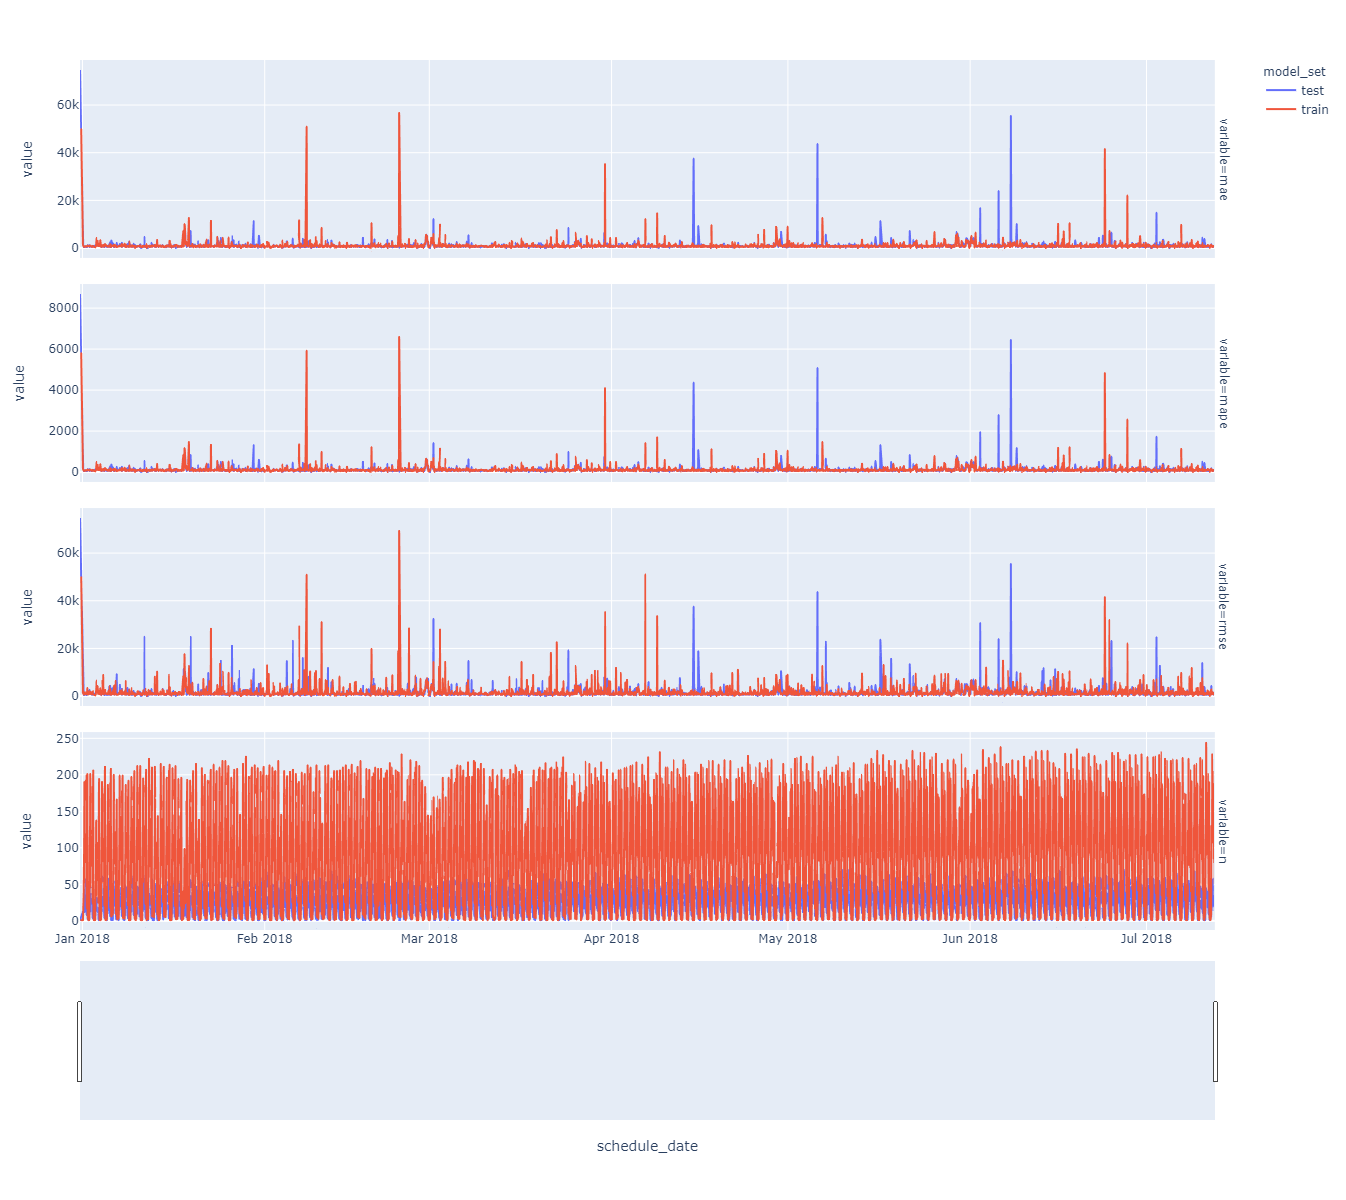

In [13]:
import plotly.express as px
fig = px.line(df_hourly_metrics_long, x="schedule_date", y="value", facet_row="variable", color="model_set",
             width=1200, height=1200)
# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    hovermode="x"
)
fig.update_yaxes(matches=None)
# fig.update_xaxes(matches=None)
fig.show()

## Plot some prediction results

In [14]:
# def predictions_daily_mean(df_predictions):
#     df_predictions["schedule_date"] = datetime_to_date(df_predictions["scheduleDateTime"])
#     df_predictions = df_predictions.drop(columns="id")
#     df_daily_mean = df_predictions.groupby(["model_set", "schedule_date"]).mean().reset_index()
#     return df_daily_mean

# def predictions_hourly_mean(df_predictions):
#     df_predictions["schedule_date"] = datetime_to_date_hour(df_predictions["scheduleDateTime"])
#     df_predictions = df_predictions.drop(columns="id")
#     df_daily_mean = df_predictions.groupby(["model_set", "schedule_date"]).mean().reset_index()
#     return df_daily_mean

# def get_safe_ylim(y, q=0.05, q2=None):
#     if q2 is None:
#         q2 = 1 - q
#     return (np.quantile(y, q), np.quantile(y, q2))


# df_daily_mean = predictions_daily_mean(df_predictions)
# y_ylim = get_safe_ylim(df_daily_mean["y"])
# error_ylim = get_safe_ylim(df_daily_mean["error"])

# df_daily_mean[["schedule_date", "y", "yhat"]].plot(x="schedule_date", ylim=y_ylim)
# df_daily_mean[["schedule_date", "error"]].plot(x="schedule_date", ylim=error_ylim)

# df_hourly_mean = predictions_hourly_mean(df_predictions)
# y_ylim = get_safe_ylim(df_hourly_mean["y"])
# error_ylim = get_safe_ylim(df_hourly_mean["error"])

# df_hourly_mean[["schedule_date", "y", "yhat"]].plot(x="schedule_date", ylim=y_ylim)
# df_hourly_mean[["schedule_date", "error"]].plot(x="schedule_date", ylim=error_ylim)

# Write output to output directory

In [15]:
import joblib, pickle
from pathlib import Path

## Pickle output files for mlflow artifacts

- Pipeline serialized with `joblib`
- Model data or sample thereof 



In [16]:
joblib.dump(avg_baseline, Path(output_dir, "model.pkl")) 

['C:\\Users\\Lodewic\\qualogy-git\\schiphol-assignment\\scripts\\model.pkl']

## Write output to CSV

Local or Google Storage is both handled

In [17]:
# write output file
write_csv_data(df_predictions, str(Path(output_dir, "predictions.csv")), index=False)
write_csv_data(df_metrics_long, str(Path(output_dir, "overall_metrics_long.csv")), index=False)
write_csv_data(df_daily_metrics_long, str(Path(output_dir, "daily_metrics_long.csv")), index=False)
write_csv_data(df_hourly_metrics_long, str(Path(output_dir, "hourly_metrics_long.csv")), index=False)

Writing file to local directory
File:	C:\Users\Lodewic\qualogy-git\schiphol-assignment\scripts\predictions.csv

Writing file to local directory
File:	C:\Users\Lodewic\qualogy-git\schiphol-assignment\scripts\overall_metrics_long.csv

Writing file to local directory
File:	C:\Users\Lodewic\qualogy-git\schiphol-assignment\scripts\daily_metrics_long.csv

Writing file to local directory
File:	C:\Users\Lodewic\qualogy-git\schiphol-assignment\scripts\hourly_metrics_long.csv



### Overview of the output data

In [18]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477778 entries, 0 to 477774
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                477778 non-null  int64              
 1   scheduleDateTime  477778 non-null  object             
 2   y                 477778 non-null  float64            
 3   yhat              477778 non-null  float64            
 4   error             477778 non-null  float64            
 5   model_set         477778 non-null  object             
 6   schedule_date     477778 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(2)
memory usage: 29.2+ MB
